# Stitching photos

In [213]:
import numpy as np
import cv2

In [214]:
# Reading images
query = cv2.imread('stitching/1.jpg')
query = cv2.resize(query, (0,0), fx=1, fy=1)
query_gray = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)

train = cv2.imread('stitching/2.jpg')
train = cv2.resize(train, (0,0), fx=1, fy=1)
train_gray = cv2.cvtColor(train, cv2.COLOR_BGR2GRAY)

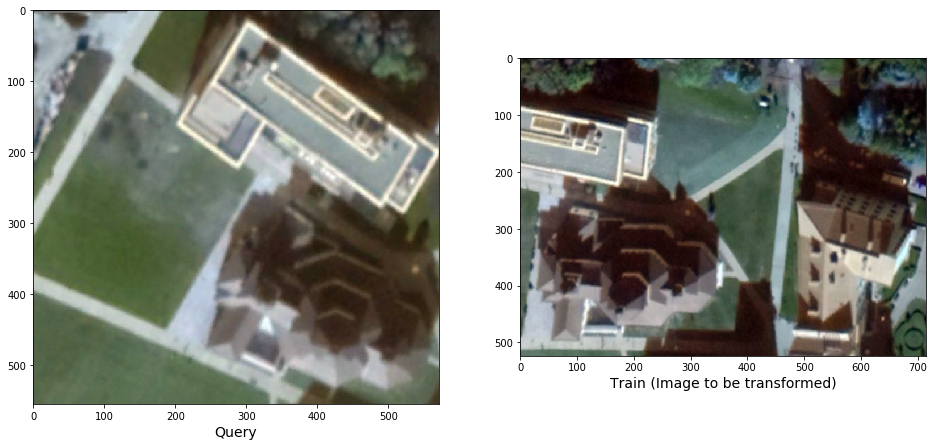

In [215]:
# Showing images
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query, cmap="gray")
ax1.set_xlabel("Query", fontsize=14)

ax2.imshow(train, cmap="gray")
ax2.set_xlabel("Train (Image to be transformed)", fontsize=14)

plt.show()

As there are several options to use feature extractor and feture matching. Let's use sift BRISK for feature extractor and brute force for feture matching.

## Keypoints and descriptors (BRISK)

In [216]:
brisk_descriptor = cv2.BRISK_create()
kpsA, featuresA = brisk_descriptor.detectAndCompute(train_gray, None)
kpsB, featuresB = brisk_descriptor.detectAndCompute(query_gray, None)

In [217]:
def showKeypoints(imageA, imageB, kpsA, kpsB):
    # display the keypoints and features detected on both images
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    ax1.imshow(cv2.drawKeypoints(imageA,kpsA,None,color=(0,255,0)))
    ax1.set_xlabel("(a)", fontsize=14)
    ax2.imshow(cv2.drawKeypoints(imageB,kpsB,None,color=(0,255,0)))
    ax2.set_xlabel("(b)", fontsize=14)

    plt.show()

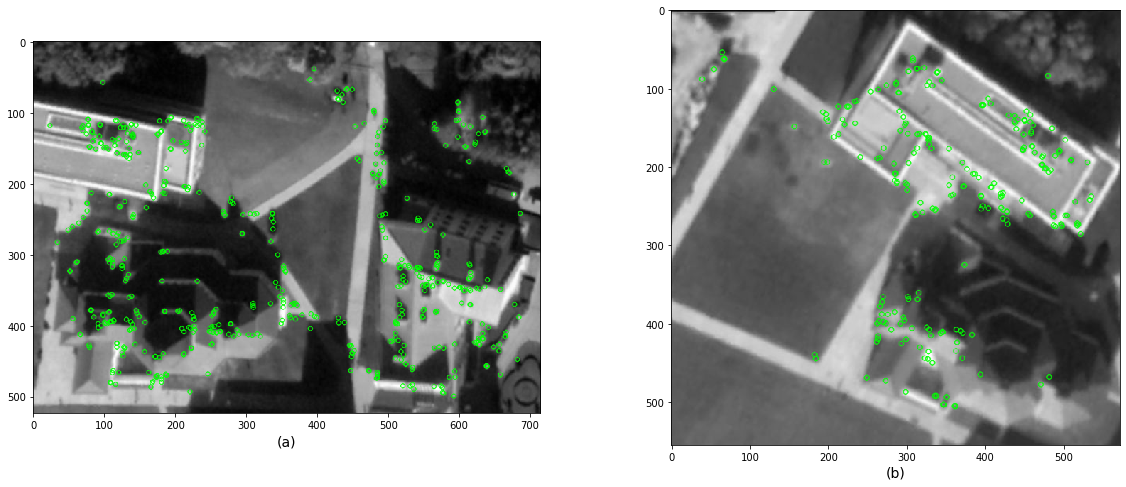

In [218]:
showKeypoints(train_gray, query_gray, kpsA, kpsB)

## Feature matching (BF)

In [219]:
def matchKeyPointsBF(matcher, featuresA, featuresB):
    # Match descriptors.
    best_matches = matcher.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [220]:
def showMatchedFeaturesBF(matches, imageA, imageB, kpsA, kpsB, number_of_matches):
    fig = plt.figure(figsize=(20,8))
    img3 = cv2.drawMatches(imageA,kpsA,imageB,kpsB,matches[:number_of_matches],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.imshow(img3)
    plt.show()

Raw matches (Brute force): 168


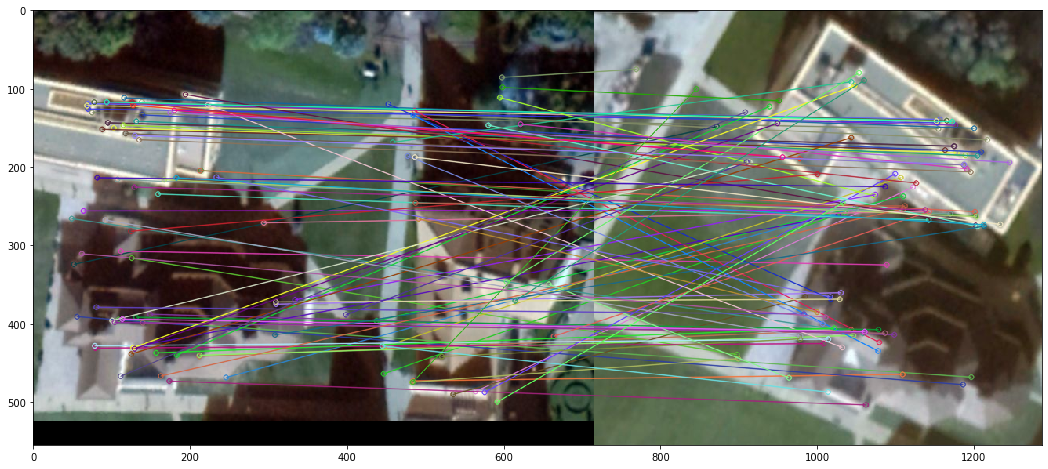

In [221]:
# Showing matched features
matches = matchKeyPointsBF(cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True), featuresA, featuresB)

number_of_matches = 100

showMatchedFeatures(matches, train, query, kpsA, kpsB, number_of_matches)

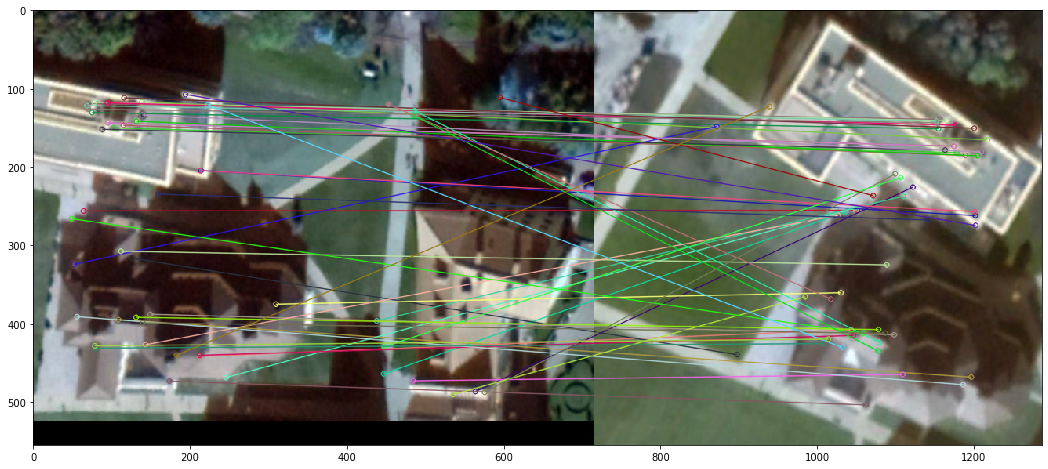

In [222]:
number_of_matches = 50

showMatchedFeatures(matches, train, query, kpsA, kpsB, number_of_matches)

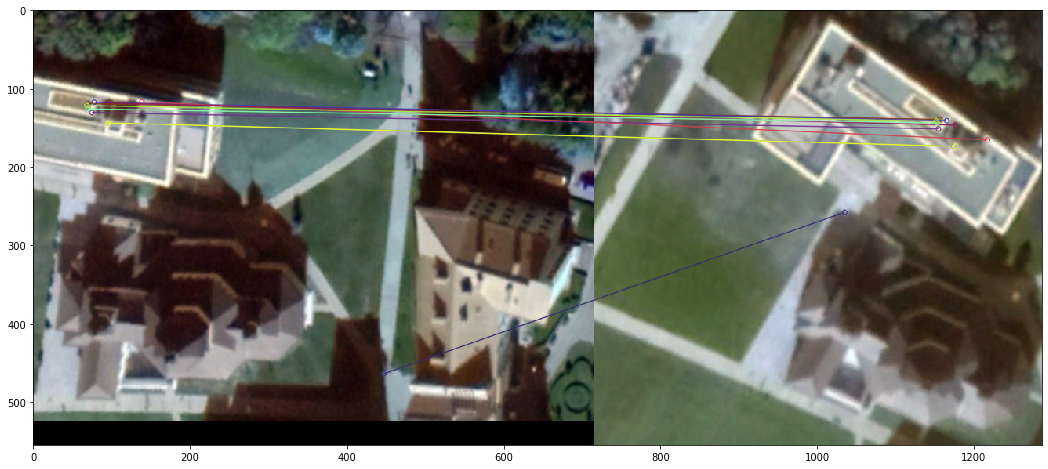

In [223]:
number_of_matches = 10

showMatchedFeatures(matches, train, query, kpsA, kpsB, number_of_matches)

As we can see, there are lot features matched in a wrong way. Let's proceed and see the final result after stitching.

In [224]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [225]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=2)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[-2.55501187e-01 -2.54801963e-01  4.38526347e+02]
 [ 1.88372514e-02  7.50517863e-01  3.24080241e+01]
 [-2.05861170e-03  2.46065890e-04  1.00000000e+00]]


In [226]:
def showStitchedImages(imageA, imageB, H):
    width = imageA.shape[1] + imageB.shape[1]
    height = imageA.shape[0] + imageB.shape[0]

    result = cv2.warpPerspective(imageA, H, (width, height))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

    plt.figure(figsize=(20,10))
    plt.imshow(result)

    plt.axis('off')
    plt.show()

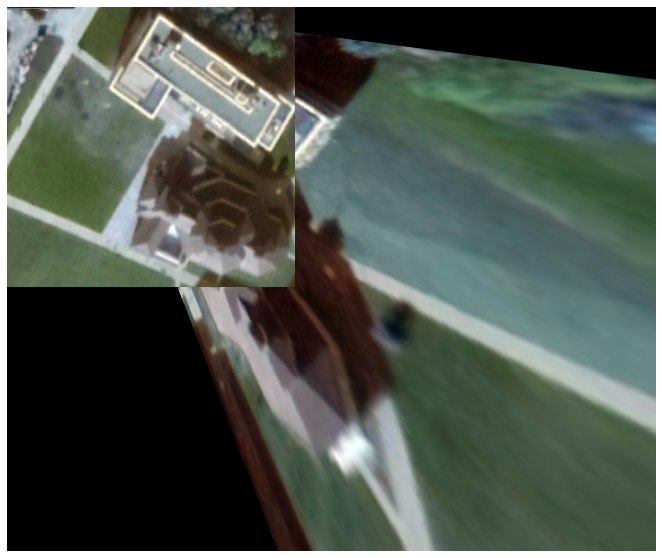

In [227]:
showStitchedImages(train, query, H)

So, yeah. Result doesn't look that great and probably we need to try another way for feature matching. Let's try KNN way.

## Feature matching (KNN)

In [228]:
def matchKeyPointsKNN(matcher, featuresA, featuresB, ratio):
    # compute the raw matches and initialize the list of actual matches
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [229]:
def showMatchedFeaturesKNN(matches, imageA, imageB, kpsA, kpsB, number_of_matches):
    fig = plt.figure(figsize=(20,8))
    img3 = cv2.drawMatches(imageA,kpsA,imageB,kpsB,np.random.choice(matches,number_of_matches),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.imshow(img3)
    plt.show()

Raw matches (knn): 564


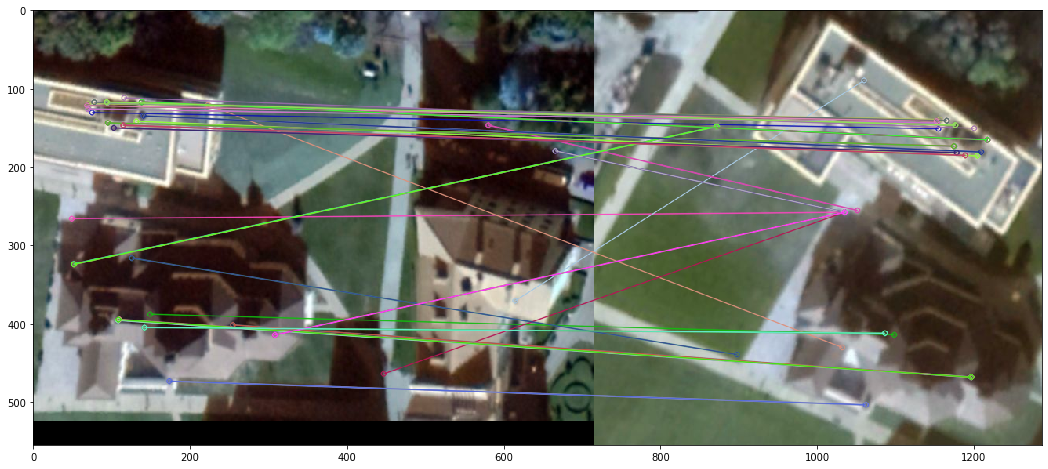

In [230]:
# Showing matched features
matches = matchKeyPointsKNN(cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False), 
                            featuresA, featuresB, ratio=0.75)

number_of_matches = 100

showMatchedFeaturesKNN(matches, train, query, kpsA, kpsB, number_of_matches)

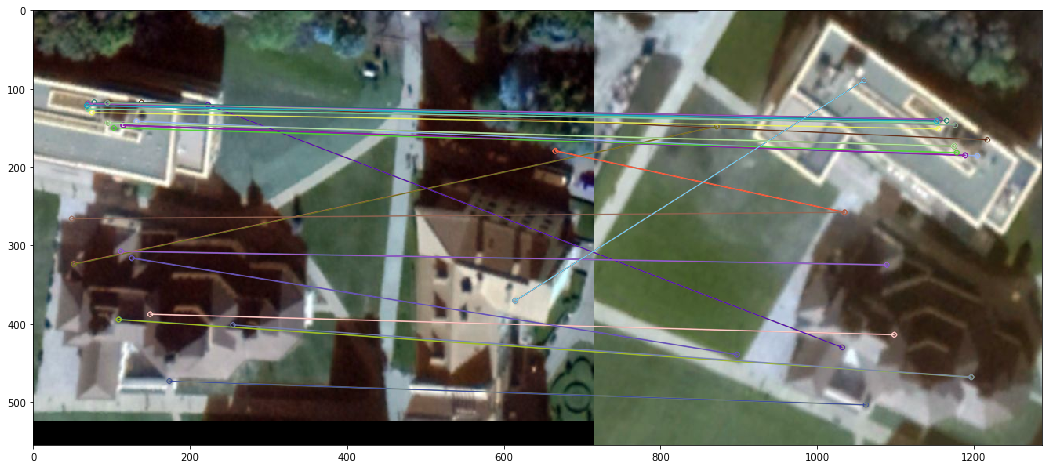

In [231]:
number_of_matches = 50

showMatchedFeaturesKNN(matches, train, query, kpsA, kpsB, number_of_matches)

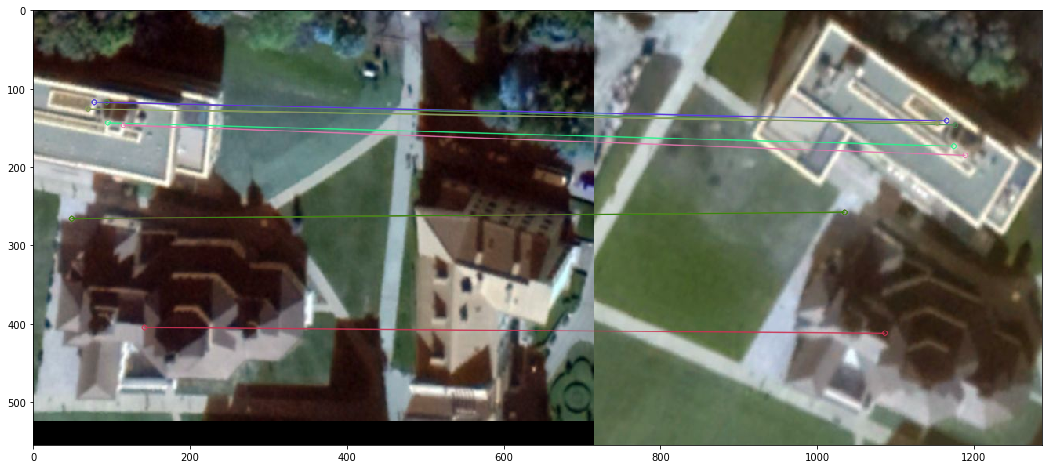

In [232]:
number_of_matches = 10

showMatchedFeaturesKNN(matches, train, query, kpsA, kpsB, number_of_matches)

At least features mathed better with KNN approach. So, let's try ro stitch them.

In [233]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=2)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 6.31250798e-01 -5.00049812e-01  4.40846058e+02]
 [ 3.16612528e-01  8.14975506e-01  1.50489680e+01]
 [-4.24258821e-04 -4.56386844e-05  1.00000000e+00]]


* reproyThresh was choosen manually, and with value = 2, it have the best look.

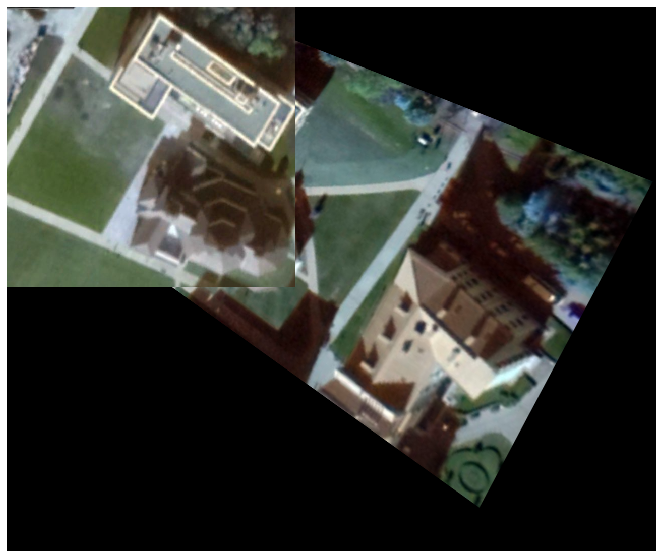

In [234]:
showStitchedImages(train, query, H)

So, here is the result. Yes the result isn't ideal, but it stitched pretty nornal. 